In [33]:
!python -V

Python 3.11.12


In [34]:
import pandas as pd
import pickle
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [36]:
   df = pd.read_parquet("/content/yellow_tripdata_2023-01.parquet")
   print(f"Number of records in Jan 2023 Yellow Taxi data: {len(df)}")
   df.head()

Number of records in Jan 2023 Yellow Taxi data: 3066766


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [37]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [38]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)


    print(f"Average trip duration in Jan 2023 Yellow Taxi data: {df.duration.mean()} minutes")

    df = df[df.duration >= 1 & (df.duration <= 60)]


    #To do one hot encoding, we use DictVectorizer which does ohe on every non numerical feature. This is int, convert it to str to do ohe
    categorical =[ 'PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    return df

In [39]:
train_df = read_dataframe("/content/yellow_tripdata_2023-01.parquet")
val_df = read_dataframe("/content/yellow_tripdata_2023-02.parquet")



Average trip duration in Jan 2023 Yellow Taxi data: 15.668995167330452 minutes
Average trip duration in Jan 2023 Yellow Taxi data: 16.01590961997241 minutes


In [63]:
train_df = train_df.fillna(-1)
val_df = val_df.fillna(-1)

In [64]:
train_df.head()
print(train_df.shape)

(3033431, 20)


In [65]:
val_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,21.9,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,14.633333
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,41.5,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,27.950000


In [66]:
print(val_df.shape)

(2882191, 20)


In [86]:
numerical = ['trip_distance']
categorical =[ 'PULocationID', 'DOLocationID']
train_df[categorical].isnull().sum()

,0
PULocationID,0
DOLocationID,0


In [68]:
categorical =[ 'PULocationID', 'DOLocationID']
print(f"Fraction of missing values: { train_df[categorical].isnull().sum().max() / train_df.shape[0] }")

Fraction of missing values: 0.0


In [87]:
train_dicts = train_df[categorical + numerical].to_dict(orient='records')

In [88]:
print(len(train_dicts))

3033431


In [89]:
val_dicts =  val_df[categorical + numerical].to_dict(orient='records')

In [90]:
#Get feature matrix
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


X_val = dv.fit_transform(val_dicts)

In [91]:
print(f"Dimensionality after OHE: {X_val.shape[-1]}")

Dimensionality after OHE: 517


In [92]:
#Then we have one feature for each pickup and dropoff location, after ohe
print(len(dv.feature_names_))

517


In [93]:
target = 'duration'
y_train = train_df[target].values
y_val = val_df[target].values

In [94]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [95]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [96]:
y_pred = lr.predict(X_train)


In [97]:
y_pred

array([12.66521577, 12.50908935, 12.84433908, ..., 13.40281138,
       14.35613766, 12.9573118 ])

In [98]:
print(len(y_pred))

3033431


<ipython-input-59-d924ba240509>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


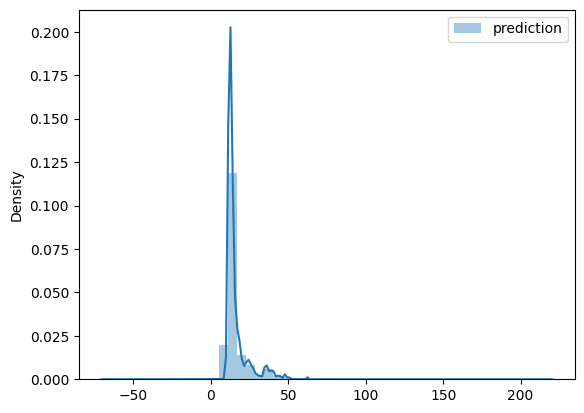

In [59]:
sns.distplot(y_pred, label='prediction')
#sns.distplot(y_train, label='actual')

plt.legend()

In [99]:
import numpy as np

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(rmse)

42.1583388761324


In [100]:
y_pred = lr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(rmse)

ValueError: X has 517 features, but LinearRegression is expecting 518 features as input.